# Compositing Rasters with Dask



An integral part of a geospatial developers workflow will occassionally require composite rasters to represent specific temporal ranges as a single image. This approach is often performed to visualize cloud-free imagery over an AOI. 

In the following example, we will create a cloud-free median composite. Using "median" as the compositing method is, one, simple, and two, provides adequate resiliency against cloud shadow/edges that are not necessarily caputured by the cloud-mask. 

In [1]:
# We will be using Sentinel-2 L2A imagery from Microsoft Planetary Computer STAC server:
!pip install planetary_computer

In [19]:
import os
import rasterio
import rioxarray
import pystac
import stackstac
import datetime
import planetary_computer
import dask
import json

import dask.array as da
import numpy as np
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import geopandas as gpd

from dask_gateway import Gateway
from pystac_client import Client
from dask.distributed import performance_report
from typing import List
from rio_cogeo.cogeo import cog_translate
from rio_cogeo.profiles import cog_profiles
from IPython.display import clear_output
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient, __version__

Set up the Dask Cluser and GCSFS Client

In [4]:
gateway = Gateway()
cluster = gateway.connect('daskhub.f3bf0be2d99540289953f8341e122568')
client = cluster.get_client()
cluster

AttributeError: 'VBox' object has no attribute '_ipython_display_'

GatewayCluster<daskhub.f3bf0be2d99540289953f8341e122568, status=running>

In [20]:
env = {
    'container_url' : os.getenv('AZURE_STORAGE_CONTAINER_URL'),
    'container_name' : os.getenv('AZURE_STORAGE_CONTAINER_NAME'),
    'container_cred' : os.getenv('AZURE_STORAGE_CONTAINER_TOK')
}

In [21]:
@dask.delayed
def write_r(env: dict, ras_pth: str, median: xr.DataArray):
    """Write a raster out to Azure blob storage
    
    Args:
        
        env: dict
            Container client variables to authenticate a client
            against the Azure Storage Container 
            
        ras_pth: str
            The remote path relative to the container to 
            save the desired raster to
            
        median: xr.DataArray
            The desired raster to save to the remote container
        
    Returns:
        If successful in saving to the remote storage container
        then a string declaring the blob has been written will 
        be returned. If unsuccessful, the Exception error string 
        will be returned.
    
    """
    import io
    import rioxarray
    container_client = ContainerClient(
        env['container_url'],
        container_name=env['container_name'],
        credential=env['container_cred']
    )
    blob_client = container_client.get_blob_client(ras_pth)
    
    with io.BytesIO() as buffer:
        median.rio.to_raster(buffer, driver="COG")
        buffer.seek(0)
        blob_client = container_client.get_blob_client(ras_pth)
        blob_client.upload_blob(buffer, overwrite=True)

    return 'success'

## AOI 

This AOI was generated from: https://www.keene.edu/campus/maps/tool/ 

In [22]:
 # Rough Polygon around Vancouver in EPSG4326
poly = {
  "coordinates": [
    [
      [
        -122.1185303,
        49.3304921
      ],
      [
        -123.3078003,
        49.3644891
      ],
      [
        -123.2528687,
        48.7742927
      ],
      [
        -122.1817017,
        48.7579995
      ],
      [
        -122.1185303,
        49.3304921
      ]
    ]
  ],
  "type": "Polygon"
}
poly

{'coordinates': [[[-122.1185303, 49.3304921],
   [-123.3078003, 49.3644891],
   [-123.2528687, 48.7742927],
   [-122.1817017, 48.7579995],
   [-122.1185303, 49.3304921]]],
 'type': 'Polygon'}

In [23]:
# We'll write this to a file, so geopanadas can open it 
poly_file_pth = '/tmp/geo.geojson'
with open(poly_file_pth, 'w') as f:
   json.dump(poly, f)

In [24]:
# Get AOI from local filesystem
f = gpd.read_file(poly_file_pth)
f

,geometry
0,"POLYGON ((-122.11853 49.33049, -123.30780 49.3..."


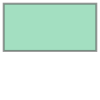

In [25]:
# The FOOTPRINT needs to be enveloped for pystac_client to query with
# More complex shapes can be be clipped with at later stages of the workflow
FOOTPRINT = f.to_crs('epsg:4326').geometry[0].envelope
FOOTPRINT

In [26]:
FOOTPRINT.bounds

(-123.3078003, 48.7579995, -122.1185303, 49.3644891)

## Set Up STAC Client

In [27]:
# Set up STAC client
api = Client.open('https://planetarycomputer.microsoft.com/api/stac/v1')
api

ID: microsoft-pc
Title: Microsoft Planetary Computer STAC API
Description: Searchable spatiotemporal metadata describing Earth science datasets hosted by the Microsoft Planetary Computer
type: Catalog
"conformsTo: ['http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/core', 'http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/geojson', 'http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/oas30', 'http://www.opengis.net/spec/ogcapi-features-3/1.0/conf/filter', 'https://api.stacspec.org/v1.0.0-rc.1/collections', 'https://api.stacspec.org/v1.0.0-rc.1/core', 'https://api.stacspec.org/v1.0.0-rc.1/item-search', 'https://api.stacspec.org/v1.0.0-rc.1/item-search#fields', 'https://api.stacspec.org/v1.0.0-rc.1/item-search#filter', 'https://api.stacspec.org/v1.0.0-rc.1/item-search#filter:basic-cql', 'https://api.stacspec.org/v1.0.0-rc.1/item-search#filter:cql-json', 'https://api.stacspec.org/v1.0.0-rc.1/item-search#filter:cql-text', 'https://api.stacspec.org/v1.0.0-rc.1/item-search#query', 'https://api.stacspec.org/v1.0.0-rc.1/item-search#sort', 'https://api.stacspec.org/v1.0.0-rc.1/ogcapi-features']"
ID: daymet-annual-pr
Title: Daymet Annual Puerto Rico
"Description: Annual climate summaries derived from [Daymet](https://daymet.ornl.gov) Version 4 daily data at a 1 km x 1 km spatial resolution for five variables: minimum and maximum temperature, precipitation, vapor pressure, and snow water equivalent. Annual averages are provided for minimum and maximum temperature, vapor pressure, and snow water equivalent, and annual totals are provided for the precipitation variable. [Daymet](https://daymet.ornl.gov/) provides measurements of near-surface meteorological conditions; the main purpose is to provide data estimates where no instrumentation exists. The dataset covers the period from January 1, 1980 to the present. Each year is processed individually at the close of a calendar year. Data are in a Lambert conformal conic projection for North America and are distributed in Zarr and NetCDF formats, compliant with the [Climate and Forecast (CF) metadata conventions (version 1.6)](http://cfconventions.org/). Use the DOI at [https://doi.org/10.3334/ORNLDAAC/1852](https://doi.org/10.3334/ORNLDAAC/1852) to cite your usage of the data. This dataset provides coverage for Hawaii; North America and Puerto Rico are provided in [separate datasets](https://planetarycomputer.microsoft.com/dataset/group/daymet#annual)."
"Providers: Microsoft (host, processor) ORNL DAAC (producer)"
type: Collection
title: Daymet Annual Puerto Rico


## Configuration

In [28]:
# CONFIG 
# -------------
BASE_PTH = 'Compositing-notebook-ouput'
OUTPUT_DIR = 'tutorial_test'
TGT_BANDS =  ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11', 'B12', 'B8A']
YEARS = ['2020']
BEGIN_MONTH = '06'
END_MONTH = '09'
MAX_CLOUD = 20.0
READ_IN_CHUNK = 4096
RESOLUTION = 10
TEMPORAL_CHUNK = {'time': -1, 'band': 1, 'x': 128, 'y': 128}
SYNCHRONOUS = False # Write bands out one at a time - use if resources can't handle all bands at once for AOI
# -------------

## Main Loop

In the main loop we iterate over the number of target years, creating a composite of each for each of the composite bands. 

In [29]:
%%time
# Main pipeline to iterate over years
write_futs = []
for year in YEARS:
    OUT_PTH = f'{BASE_PTH}/{OUTPUT_DIR}/{year}'
    date_range = f'{year}-{BEGIN_MONTH}-01/{year}-{END_MONTH}-30'
    
    # Query the Planetary Computer STAC server with pystac_client
    print(f'[Querying] {year}')
    items = api.search(
        collections = ['sentinel-2-l2a'],
        intersects = FOOTPRINT,
        query={"eo:cloud_cover": {"lt": MAX_CLOUD}},
        datetime = date_range,
    ).get_all_items()
    
    print(f'\tFound {len(items)} items')
    # planetarycomputer requires signed URLs to access Asset HREFs. 
    print('\t[Signing data links]')
    signed_items = [planetary_computer.sign(item).to_dict() for item in items]
    
    # Pull out SCL DataArray before bands are looped through
    # since this will not change per band. 
    scl_stk = (
        stackstac.stack(
            signed_items,
            assets=['SCL'], 
            chunksize=READ_IN_CHUNK, # Set chunksize
            resolution=RESOLUTION, # Set all bands res to this
            bounds_latlon=FOOTPRINT.bounds, # clip to AOI bounds
        )
    )
    # Create binary mask [np.nan, 1]
    # https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm
    scl_stk.data = da.where(
            ((scl_stk.data==0)| # nodata
             (scl_stk.data==1)| # Saturated or Defective
             (scl_stk.data==8)| # cloud: medium probability
             (scl_stk.data==9)| # cloud: high probability
             (scl_stk.data==10)| # cloud: thin cirrus
             (scl_stk.data==11) # snow
            ), np.nan, 1)
    
    # Iterate over bands and build composite DAG
    for band in TGT_BANDS:
        clear_output(wait=True) # clear Jupyter Cell output
        print(f'[Processing {band}]')

        # Convert STAC query into a xarray.DataArray
        # with stackstac
        print('\t[Converting STAC query to DataArray]')
        data = (
            stackstac.stack(
                signed_items,
                assets=[band], 
                chunksize=READ_IN_CHUNK, # Set chunksize
                resolution=RESOLUTION, # Set all bands res to this
                bounds_latlon=FOOTPRINT.bounds, # clip to AOI bounds
            ).where(lambda x: x > 0, other=np.nan) # Convert nodata zero to np.nan
        )
        
        # Mask the bands with the accompanying SCL band per time
        print('\t[Masking data with SCL]')
        masked = data.copy()
        masked.data = data.data * scl_stk.data # np.nan will mask unwated pixels
        
        # Create median composite
        print('\t[Creating Median composite]')
        # skip np.nan in temporal stack with skipna=True
        median = masked.median(dim='time', skipna=True, keep_attrs=True)
        median = median.chunk({'band': 1, 'y': 'auto', 'x': 'auto'})
        median = median.transpose('band', 'y', 'x')
    
        # Cast the xarray.DataArray to int16
        median = median.astype(np.uint16)

        # Get EPSG from median metadata
        epsg = median.coords['epsg'].values.tolist()

        
        if SYNCHRONOUS:
            # Issues with large AOI's - limited resources - so compute each composite
            # individually to relieve the Dask Cluster
            print(dask.compute(write_r(env, f'{OUT_PTH}/{band}.tif', median)))
        else:
            # Write out each band to a file asynchronously
            print(f'\t[Processing and Writing {band}]')
            median.name = band
            median.attrs['long_name'] = band
            write_futs.append(write_r(env, f'{OUT_PTH}/{band}.tif', median))

if not SYNCHRONOUS:
    clear_output(wait=True)
    # write_futs.visualize()
    with performance_report('dask_report.html'):
        print(dask.compute(write_futs)[0])

['success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success', 'success']
CPU times: user 3.39 s, sys: 133 ms, total: 3.52 s
Wall time: 5min 51s


## Shut Dask Cluster Down

Make sure to shut down the Dask Cluster as not to incur costs

In [30]:
cluster.shutdown()

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:1014: RuntimeWarning: coroutine 'rpc.close_rpc' was never awaited
  self.scheduler_comm.close_rpc()
